# Synthetic Apache Attack Detection - Model Evaluation

This notebook evaluates the OpenStack-trained model on **synthetic Apache logs with known attacks**.

**Test Dataset:**
- 10,000+ Apache access logs (Node.js application)
- 15% known anomalies with labeled attack types:
  - SQL Injection
  - Cross-Site Scripting (XSS)
  - Path Traversal
  - Command Injection
  - Vulnerability Scanning
  - Brute Force Attacks

**Evaluation Goals:**
1. Measure detection accuracy (Precision, Recall, F1-Score)
2. Analyze which attack types are detected
3. Test cross-domain generalization capability
4. Generate confusion matrix and ROC curves

In [1]:
import json
import math
import re
from pathlib import Path
from collections import defaultdict, Counter

import yaml
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    precision_recall_curve, f1_score, accuracy_score
)

plt.style.use('seaborn-v0_8-darkgrid' if 'seaborn-v0_8-darkgrid' in plt.style.available else 'default')
%matplotlib inline

/home/tpi/anaconda3/envs/log_anomaly/lib/python3.11/site-packages/torch/cuda/__init__.py:54: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
# Setup paths
CWD = Path.cwd().resolve()
REPO_ROOT = CWD.parent if CWD.name == 'notebooks' else CWD

cfg = yaml.safe_load((REPO_ROOT / 'configs/train_openstack.yaml').read_text())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Device: {device}")
print(f"Repo root: {REPO_ROOT}")

Device: cuda
Repo root: /home/tpi/distil_shahreyar


## 1. Load Synthetic Logs and Ground Truth Labels

In [3]:
# Load synthetic logs
log_file = REPO_ROOT / 'data/apache_logs/synthetic_nodejs_apache_10k.log'
label_file = REPO_ROOT / 'data/apache_logs/synthetic_apache_labels.json'

print(f"Loading logs from: {log_file}")
print(f"Loading labels from: {label_file}")

# Load ground truth labels
with open(label_file, 'r') as f:
    label_data = json.load(f)

metadata = label_data['metadata']
ground_truth = label_data['labels']

print(f"\n{'='*70}")
print(f"GROUND TRUTH DATASET INFO")
print(f"{'='*70}")
print(f"Total logs:          {metadata['total_logs']:,}")
print(f"Normal logs:         {metadata['normal_logs']:,} ({metadata['normal_logs']/metadata['total_logs']*100:.1f}%)")
print(f"Anomalous logs:      {metadata['anomalous_logs']:,} ({metadata['anomalous_logs']/metadata['total_logs']*100:.1f}%)")
print(f"\nAttack distribution:")
for attack_type, count in metadata['attack_distribution'].items():
    print(f"  {attack_type:<25} {count:,}")

Loading logs from: /home/tpi/distil_shahreyar/data/apache_logs/synthetic_nodejs_apache_10k.log
Loading labels from: /home/tpi/distil_shahreyar/data/apache_logs/synthetic_apache_labels.json

GROUND TRUTH DATASET INFO
Total logs:          10,050
Normal logs:         8,500 (84.6%)
Anomalous logs:      1,500 (14.9%)

Attack distribution:
  sql_injection             375
  xss                       300
  path_traversal            225
  command_injection         150
  scanning                  450


## 2. Parse Logs (Reuse Existing Parser)

In [4]:
# Apache log parser (same as before)
APACHE_PATTERN = re.compile(
    r'^(?P<ip>\S+) \S+ \S+ '
    r'\[(?P<timestamp>[^\]]+)\] '
    r'"(?P<method>\S+) (?P<path>\S+) (?P<protocol>\S+)" '
    r'(?P<status>\d+) '
    r'(?P<size>\S+)'
    r'(?: "(?P<referrer>[^"]*)")?'
    r'(?: "(?P<user_agent>[^"]*)")?'
)

RE_IPv4 = re.compile(r'\b(?:(?:25[0-5]|2[0-4]\d|1?\d?\d)\.){3}(?:25[0-5]|2[0-4]\d|1?\d?\d)\b')
RE_NUM = re.compile(r'(?<![A-Za-z])[-+]?\d+(?:\.\d+)?(?![A-Za-z])')
RE_PATH = re.compile(r'(?:/[^/\s]+)+')
RE_URL = re.compile(r'https?://\S+')

def normalize_apache_message(msg: str) -> str:
    if not msg:
        return msg
    out = msg
    out = RE_URL.sub('<URL>', out)
    out = RE_IPv4.sub('<IP>', out)
    
    def normalize_path(match):
        path = match.group(0)
        path = re.sub(r'/\d+', '/<NUM>', path)
        path = re.sub(r'/[0-9a-fA-F]{8,}', '/<HEX>', path)
        return path
    
    out = RE_PATH.sub(normalize_path, out)
    
    def bucket_number(m):
        s = m.group(0)
        try:
            val = float(s) if '.' in s else int(s)
            if val == 0:
                return '<NUM_E0>'
            mag = int(math.floor(math.log10(abs(val))))
            return f'<NUM_E{mag}>'
        except:
            return '<NUM>'
    
    out = RE_NUM.sub(bucket_number, out)
    return re.sub(r'\s+', ' ', out).strip()

def parse_apache_log(log_path: Path):
    records = []
    with open(log_path, 'r', encoding='utf-8', errors='ignore') as f:
        for line_num, line in enumerate(f, 1):
            line = line.strip()
            if not line:
                continue
            
            match = APACHE_PATTERN.match(line)
            if not match:
                records.append({
                    'timestamp': pd.NaT,
                    'ip': None,
                    'method': None,
                    'path': None,
                    'status': None,
                    'size': None,
                    'raw_message': line,
                    'norm_message': normalize_apache_message(line),
                    'line_num': line_num
                })
                continue
            
            d = match.groupdict()
            try:
                ts = pd.to_datetime(d['timestamp'], format='%d/%b/%Y:%H:%M:%S %z', errors='coerce')
            except:
                ts = pd.NaT
            
            message = f"{d.get('method', 'GET')} {d.get('path', '/')} {d.get('protocol', 'HTTP/1.1')} {d.get('status', '200')}"
            
            records.append({
                'timestamp': ts,
                'ip': d['ip'],
                'method': d.get('method'),
                'path': d.get('path'),
                'status': d.get('status'),
                'size': d.get('size'),
                'raw_message': message,
                'norm_message': normalize_apache_message(message),
                'line_num': line_num
            })
    
    df = pd.DataFrame(records)
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    return df

print("Parsing synthetic Apache logs...")
df = parse_apache_log(log_file)

# Add ground truth labels to DataFrame
df['true_label'] = df['line_num'].apply(lambda x: ground_truth[str(x)]['is_anomaly'] if str(x) in ground_truth else False)
df['attack_type'] = df['line_num'].apply(lambda x: ground_truth[str(x)].get('attack_type', None) if str(x) in ground_truth else None)
df['severity'] = df['line_num'].apply(lambda x: ground_truth[str(x)].get('severity', 'normal') if str(x) in ground_truth else 'normal')

print(f"\nParsed {len(df):,} log entries")
print(f"True anomalies: {df['true_label'].sum():,}")
print(f"True normal:    {(~df['true_label']).sum():,}")

Parsing synthetic Apache logs...

Parsed 10,050 log entries
True anomalies: 1,550
True normal:    8,500

Parsed 10,050 log entries
True anomalies: 1,550
True normal:    8,500


## 3. Template Extraction & Mapping

In [5]:
# Load OpenStack vocabulary
data_cfg = cfg['data']
vocab_path = (REPO_ROOT / data_cfg['vocab_path']).resolve()
vocab = json.loads(vocab_path.read_text())

openstack_vocab_size = len(vocab.get('id_to_template', []))
id_to_template = vocab['id_to_template']
template_to_id = {t: i for i, t in enumerate(id_to_template)}

# Map Apache templates
UNK_ID = max(0, openstack_vocab_size - 1)

apache_template_to_id = {}
apache_id_to_template = []
template_counts = Counter()

template_ids = []
for norm_msg in df['norm_message']:
    if norm_msg in template_to_id:
        tid = template_to_id[norm_msg]
    else:
        tid = UNK_ID
    
    if norm_msg not in apache_template_to_id:
        apache_tid = len(apache_id_to_template)
        apache_template_to_id[norm_msg] = apache_tid
        apache_id_to_template.append(norm_msg)
    
    template_ids.append(tid)
    template_counts[tid] += 1

df['template_id'] = template_ids
df['apache_template_id'] = [apache_template_to_id[msg] for msg in df['norm_message']]

matched_count = sum(1 for tid in template_ids if tid != UNK_ID)
unk_count = sum(1 for tid in template_ids if tid == UNK_ID)

print(f"Template Mapping Summary:")
print(f"  Unique Apache templates: {len(apache_id_to_template):,}")
print(f"  Matched to OpenStack:    {matched_count:,} ({matched_count/len(df)*100:.1f}%)")
print(f"  Mapped to UNK:           {unk_count:,} ({unk_count/len(df)*100:.1f}%)")

Template Mapping Summary:
  Unique Apache templates: 375
  Matched to OpenStack:    0 (0.0%)
  Mapped to UNK:           10,050 (100.0%)


## 4. Create Sequences with Ground Truth Labels

In [6]:
# Create sequences (by IP address, sliding window)
WINDOW_SIZE = 20
STRIDE = 10

sequences = []
sequence_labels = []  # Ground truth for each sequence
session_info = []

df_sorted = df.sort_values('timestamp').reset_index(drop=True)

for ip, group in df_sorted.groupby('ip'):
    templates = group['template_id'].tolist()
    true_labels = group['true_label'].tolist()
    timestamps = group['timestamp'].tolist()
    line_nums = group['line_num'].tolist()
    
    if len(templates) < 2:
        continue
    
    for i in range(0, len(templates) - 1, STRIDE):
        window = templates[i:i + WINDOW_SIZE]
        window_labels = true_labels[i:i + WINDOW_SIZE]
        
        if len(window) < 2:
            continue
        
        sequences.append(window)
        
        # Sequence is anomalous if ANY log in it is anomalous
        seq_is_anomaly = any(window_labels)
        sequence_labels.append(seq_is_anomaly)
        
        session_info.append({
            'session_id': f"{ip}_{i}",
            'ip': ip,
            'start_time': timestamps[i],
            'end_time': timestamps[min(i + len(window) - 1, len(timestamps) - 1)],
            'start_line': line_nums[i],
            'end_line': line_nums[min(i + len(window) - 1, len(line_nums) - 1)],
            'length': len(window),
            'true_label': seq_is_anomaly
        })

print(f"\n{'='*70}")
print(f"SEQUENCE CREATION WITH LABELS")
print(f"{'='*70}")
print(f"Total sequences:          {len(sequences):,}")
print(f"True anomalous sequences: {sum(sequence_labels):,} ({sum(sequence_labels)/len(sequence_labels)*100:.1f}%)")
print(f"True normal sequences:    {len(sequence_labels) - sum(sequence_labels):,} ({(len(sequence_labels) - sum(sequence_labels))/len(sequence_labels)*100:.1f}%)")


SEQUENCE CREATION WITH LABELS
Total sequences:          979
True anomalous sequences: 101 (10.3%)
True normal sequences:    878 (89.7%)


## 5. Load Model & Compute Scores

In [7]:
# Clear CUDA cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    print("✓ CUDA cache cleared")

✓ CUDA cache cleared


In [8]:
# Model definition (same as before)
class TemplateTransformer(nn.Module):
    def __init__(self, vocab_size: int, pad_id: int, d_model: int, n_layers: int, n_heads: int,
                 ffn_dim: int, dropout: float, max_length: int):
        super().__init__()
        self.pad_id = pad_id
        self.max_length = max_length
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=pad_id)
        self.positional = nn.Parameter(torch.zeros(1, max_length, d_model))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads, dim_feedforward=ffn_dim,
            dropout=dropout, batch_first=True, activation='gelu'
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(d_model)
        self.output = nn.Linear(d_model, vocab_size)
        self.register_buffer('causal_mask', torch.triu(torch.ones(max_length, max_length), diagonal=1).bool(), persistent=False)

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor):
        seq_len = input_ids.size(1)
        x = self.embedding(input_ids)
        x = x + self.positional[:, :seq_len, :]
        causal = self.causal_mask[:seq_len, :seq_len]
        causal = causal.float().masked_fill(causal, float('-inf'))
        key_padding = attention_mask == 0
        x = self.encoder(x, mask=causal, src_key_padding_mask=key_padding)
        x = self.dropout(self.norm(x))
        logits = self.output(x)
        return logits

# Load model
pad_strategy = data_cfg.get('pad_token_strategy', 'vocab_size')
if pad_strategy == 'vocab_size':
    pad_id = openstack_vocab_size
    vocab_size = openstack_vocab_size + 1
else:
    pad_id = int(pad_strategy)
    vocab_size = max(openstack_vocab_size + 1, pad_id + 1)

max_seq_len = data_cfg.get('max_sequence_length', 100)
model_cfg = cfg['model']

model = TemplateTransformer(
    vocab_size=vocab_size, pad_id=pad_id, d_model=model_cfg['d_model'],
    n_layers=model_cfg['n_layers'], n_heads=model_cfg['n_heads'],
    ffn_dim=model_cfg['ffn_dim'], dropout=model_cfg['dropout'],
    max_length=max_seq_len,
).to(device)

checkpoint_dir = (REPO_ROOT / cfg['checkpointing']['output_dir']).resolve()
best_path = checkpoint_dir / 'best.pt'

state = torch.load(best_path, map_location=device)
model.load_state_dict(state['model_state_dict'])
model.eval()

print(f"✓ Model loaded from {best_path}")
print(f"  Epoch: {state.get('epoch', 'N/A')}")
print(f"  Val Loss: {state.get('val_loss', 'N/A'):.4f}" if state.get('val_loss') else "")

✓ Model loaded from /home/tpi/distil_shahreyar/artifacts/openstack_finetune_model/best.pt
  Epoch: 10
  Val Loss: 0.2649


In [9]:
# Dataset & DataLoader
class TemplateSequenceDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self, idx):
        return self.sequences[idx]

class TemplateBatchCollator:
    def __init__(self, pad_id: int, max_length: int):
        self.pad_id = pad_id
        self.max_length = max_length
    
    def __call__(self, batch):
        truncated = [seq[:self.max_length] for seq in batch if len(seq) > 1]
        if not truncated:
            truncated = [batch[0][:self.max_length]]
        
        max_len = max(len(seq) for seq in truncated)
        input_len = max_len - 1
        bs = len(truncated)
        
        input_ids = torch.full((bs, input_len), self.pad_id, dtype=torch.long)
        target_ids = torch.full((bs, input_len), self.pad_id, dtype=torch.long)
        attention_mask = torch.zeros((bs, input_len), dtype=torch.long)
        
        for i, seq in enumerate(truncated):
            src = seq[:-1]
            tgt = seq[1:]
            input_ids[i, :len(src)] = torch.tensor(src, dtype=torch.long)
            target_ids[i, :len(tgt)] = torch.tensor(tgt, dtype=torch.long)
            attention_mask[i, :len(src)] = 1
        
        return {'input_ids': input_ids, 'target_ids': target_ids, 'attention_mask': attention_mask}

dataset = TemplateSequenceDataset(sequences)
collator = TemplateBatchCollator(pad_id=pad_id, max_length=max_seq_len)
loader = DataLoader(dataset, batch_size=32, shuffle=False, collate_fn=collator)

print(f"Created dataloader with {len(sequences):,} sequences")

Created dataloader with 979 sequences


In [10]:
# Compute anomaly scores
def compute_sequence_scores(model, loader, vocab_size, pad_id, device, unk_id):
    model.eval()
    all_scores = []
    
    with torch.no_grad():
        for batch in tqdm(loader, desc="Computing scores"):
            input_ids = batch['input_ids'].to(device)
            target_ids = batch['target_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            logits = model(input_ids, attention_mask)
            
            for i in range(input_ids.size(0)):
                seq_logits = logits[i]
                seq_targets = target_ids[i]
                seq_mask = attention_mask[i]
                
                valid_mask = (seq_targets != pad_id) & (seq_mask == 1)
                if valid_mask.sum() == 0:
                    continue
                
                valid_logits = seq_logits[valid_mask]
                valid_targets = seq_targets[valid_mask]
                
                nll_per_pos = F.cross_entropy(valid_logits, valid_targets, reduction='none')
                
                avg_nll = nll_per_pos.mean().item()
                max_nll = nll_per_pos.max().item()
                avg_ppl = math.exp(min(avg_nll, 50))
                
                full_seq = torch.cat([input_ids[i], target_ids[i, -1:]])
                full_seq = full_seq[full_seq != pad_id]
                unseen_count = (full_seq == unk_id).sum().item()
                unseen_rate = unseen_count / len(full_seq) if len(full_seq) > 0 else 0.0
                
                probs = F.softmax(valid_logits, dim=-1)
                entropy = -(probs * torch.log(probs + 1e-10)).sum(dim=-1).mean().item()
                
                all_scores.append({
                    'avg_nll': avg_nll,
                    'max_nll': max_nll,
                    'avg_ppl': avg_ppl,
                    'unseen_rate': unseen_rate,
                    'entropy': entropy
                })
    
    return pd.DataFrame(all_scores)

print("Computing anomaly scores...")
scores_df = compute_sequence_scores(model, loader, vocab_size, pad_id, device, UNK_ID)

# Add session info and ground truth
for col, vals in pd.DataFrame(session_info).items():
    scores_df[col] = vals.values[:len(scores_df)]

print(f"\n✓ Computed scores for {len(scores_df):,} sequences")

Computing anomaly scores...


Computing scores:   0%|          | 0/31 [00:00<?, ?it/s]

/home/tpi/anaconda3/envs/log_anomaly/lib/python3.11/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(



✓ Computed scores for 979 sequences


## 6. Detection Performance Evaluation

In [11]:
# Apply detection thresholds (90th percentile)
nll_threshold = np.percentile(scores_df['avg_nll'], 90)
ppl_threshold = np.percentile(scores_df['avg_ppl'], 90)
entropy_threshold = np.percentile(scores_df['entropy'], 90)

scores_df['pred_anomaly_nll'] = (scores_df['avg_nll'] > nll_threshold).astype(int)
scores_df['pred_anomaly_ppl'] = (scores_df['avg_ppl'] > ppl_threshold).astype(int)
scores_df['pred_anomaly_entropy'] = (scores_df['entropy'] > entropy_threshold).astype(int)

# Combined prediction (NLL AND Entropy) OR PPL
scores_df['pred_anomaly_combined'] = (
    ((scores_df['pred_anomaly_nll'] == 1) & (scores_df['pred_anomaly_entropy'] == 1)) |
    (scores_df['pred_anomaly_ppl'] == 1)
).astype(int)

# Ground truth
y_true = scores_df['true_label'].astype(int).values
y_pred = scores_df['pred_anomaly_combined'].values

print(f"\n{'='*70}")
print(f"DETECTION PERFORMANCE (Combined Method)")
print(f"{'='*70}")
print(f"\nThresholds:")
print(f"  NLL:     {nll_threshold:.4f}")
print(f"  PPL:     {ppl_threshold:.2f}")
print(f"  Entropy: {entropy_threshold:.4f}")

print(f"\n{classification_report(y_true, y_pred, target_names=['Normal', 'Anomaly'], digits=4)}")

# Additional metrics
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Overall Metrics:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  F1-Score: {f1:.4f}")


DETECTION PERFORMANCE (Combined Method)

Thresholds:
  NLL:     10.4417
  PPL:     34259.82
  Entropy: 0.6877

              precision    recall  f1-score   support

      Normal     0.9073    0.9146    0.9109       878
     Anomaly     0.2021    0.1881    0.1949       101

    accuracy                         0.8396       979
   macro avg     0.5547    0.5513    0.5529       979
weighted avg     0.8346    0.8396    0.8371       979

Overall Metrics:
  Accuracy: 0.8396
  F1-Score: 0.1949


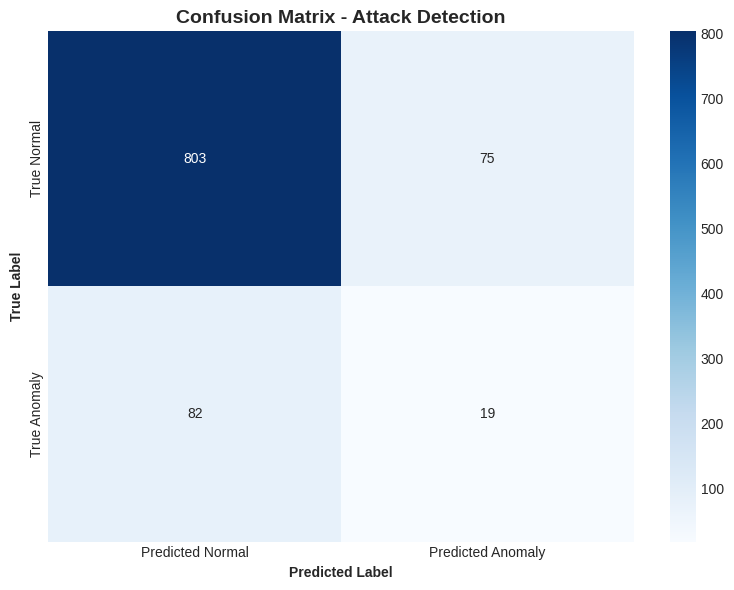


Confusion Matrix:
  True Negatives (TN):  803
  False Positives (FP): 75
  False Negatives (FN): 82
  True Positives (TP):  19


In [12]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Normal', 'Predicted Anomaly'],
            yticklabels=['True Normal', 'True Anomaly'])
plt.title('Confusion Matrix - Attack Detection', fontweight='bold', fontsize=14)
plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.tight_layout()
plt.savefig(REPO_ROOT / 'artifacts/metrics/apache/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nConfusion Matrix:")
print(f"  True Negatives (TN):  {cm[0,0]:,}")
print(f"  False Positives (FP): {cm[0,1]:,}")
print(f"  False Negatives (FN): {cm[1,0]:,}")
print(f"  True Positives (TP):  {cm[1,1]:,}")

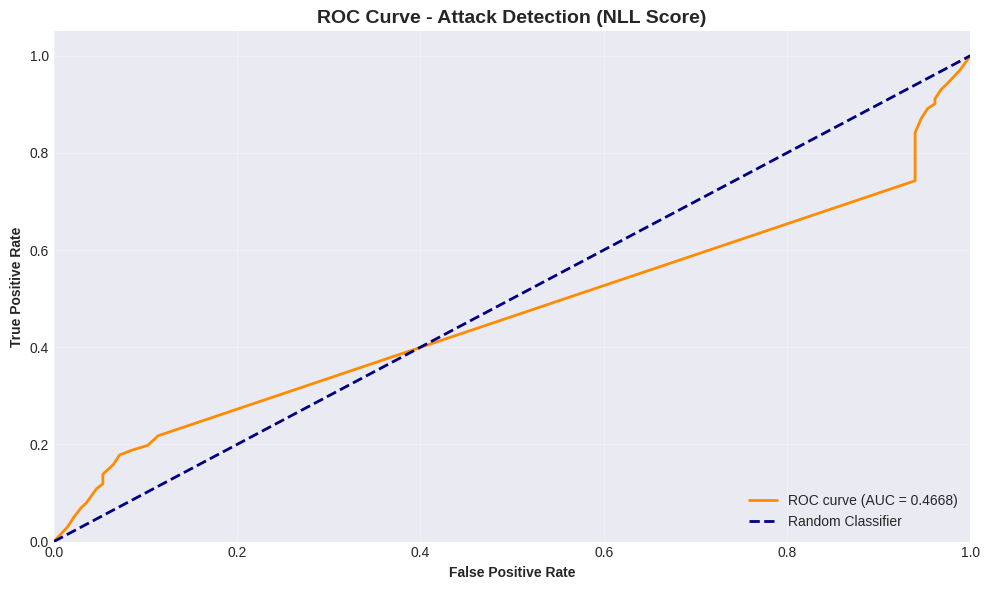


ROC AUC Score: 0.4668


In [13]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, scores_df['avg_nll'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
plt.title('ROC Curve - Attack Detection (NLL Score)', fontweight='bold', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(REPO_ROOT / 'artifacts/metrics/apache/roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nROC AUC Score: {roc_auc:.4f}")

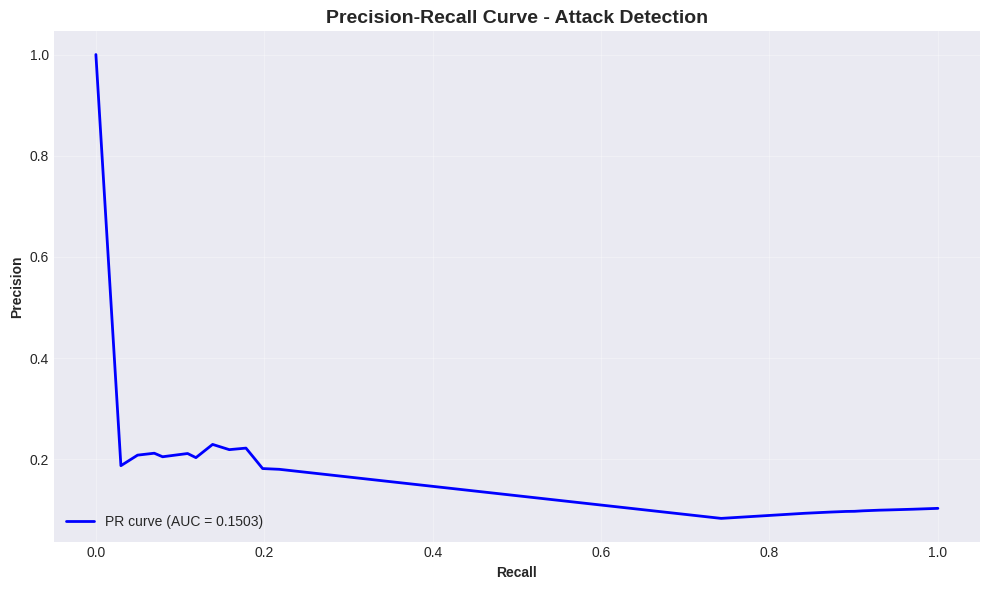


Precision-Recall AUC: 0.1503


In [14]:
# Precision-Recall Curve
precision, recall, pr_thresholds = precision_recall_curve(y_true, scores_df['avg_nll'])
pr_auc = auc(recall, precision)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall', fontweight='bold')
plt.ylabel('Precision', fontweight='bold')
plt.title('Precision-Recall Curve - Attack Detection', fontweight='bold', fontsize=14)
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(REPO_ROOT / 'artifacts/metrics/apache/precision_recall_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nPrecision-Recall AUC: {pr_auc:.4f}")

## 7. Attack Type Analysis


DETECTION BY ATTACK TYPE
      attack_type  total  detected  detection_rate
    sql_injection    375         0             0.0
              xss    300         0             0.0
   path_traversal    225         0             0.0
command_injection    150         0             0.0
         scanning    450         0             0.0


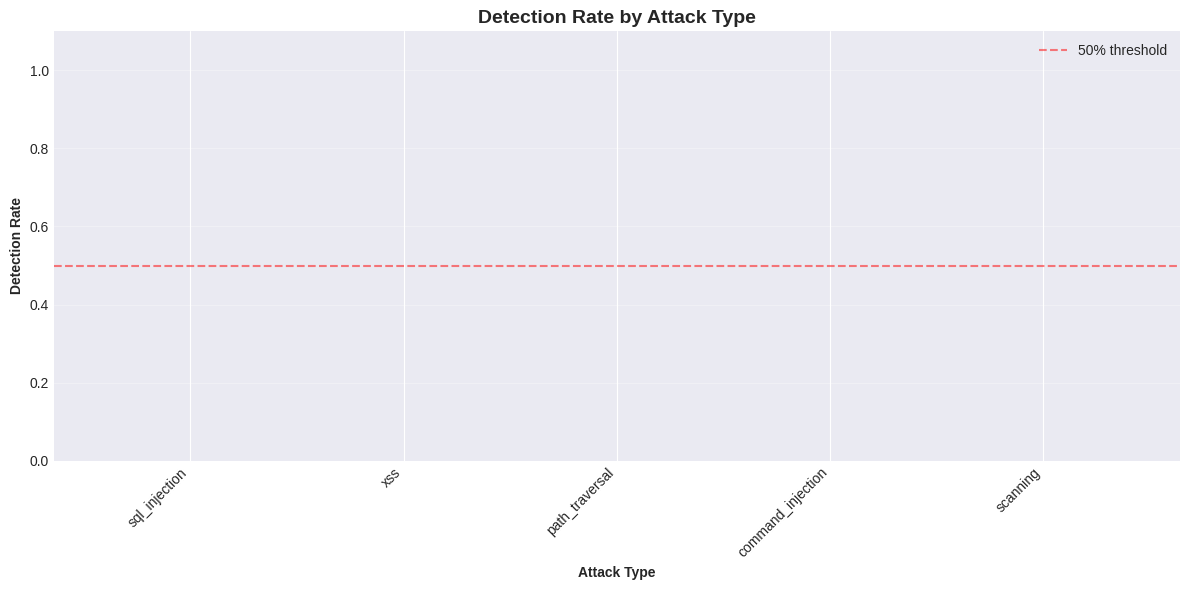

In [15]:
# Analyze detection by attack type
# Map sequence-level predictions back to log-level
log_predictions = {}

for idx, row in scores_df.iterrows():
    for line_num in range(row['start_line'], row['end_line'] + 1):
        if line_num not in log_predictions:
            log_predictions[line_num] = []
        log_predictions[line_num].append(row['pred_anomaly_combined'])

# Aggregate predictions (majority vote)
df['pred_anomaly'] = df['line_num'].apply(
    lambda x: int(np.mean(log_predictions.get(x, [0])) > 0.5) if x in log_predictions else 0
)

# Attack type analysis
attack_analysis = []
for attack_type in ['sql_injection', 'xss', 'path_traversal', 'command_injection', 'scanning']:
    attack_logs = df[df['attack_type'] == attack_type]
    if len(attack_logs) > 0:
        detected = attack_logs['pred_anomaly'].sum()
        total = len(attack_logs)
        detection_rate = detected / total
        
        attack_analysis.append({
            'attack_type': attack_type,
            'total': total,
            'detected': detected,
            'detection_rate': detection_rate
        })

attack_df = pd.DataFrame(attack_analysis)

print(f"\n{'='*70}")
print(f"DETECTION BY ATTACK TYPE")
print(f"{'='*70}")
print(attack_df.to_string(index=False))

# Visualization
plt.figure(figsize=(12, 6))
x = range(len(attack_df))
plt.bar(x, attack_df['detection_rate'], color='steelblue', alpha=0.7)
plt.xlabel('Attack Type', fontweight='bold')
plt.ylabel('Detection Rate', fontweight='bold')
plt.title('Detection Rate by Attack Type', fontweight='bold', fontsize=14)
plt.xticks(x, attack_df['attack_type'], rotation=45, ha='right')
plt.ylim([0, 1.1])
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='50% threshold')
plt.grid(True, alpha=0.3, axis='y')
plt.legend()
plt.tight_layout()
plt.savefig(REPO_ROOT / 'artifacts/metrics/apache/detection_by_attack_type.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Example Detections & Misses

In [16]:
# True Positives (correctly detected attacks)
true_positives = df[(df['true_label'] == True) & (df['pred_anomaly'] == 1)]
print(f"\n{'='*70}")
print(f"SAMPLE TRUE POSITIVES (Correctly Detected Attacks)")
print(f"{'='*70}")
for i, row in true_positives.head(5).iterrows():
    print(f"\n[{row['attack_type'].upper()}] Line {row['line_num']}:")
    print(f"  {row['method']} {row['path']} → {row['status']}")
    print(f"  Severity: {row['severity']}")


SAMPLE TRUE POSITIVES (Correctly Detected Attacks)


In [17]:
# False Negatives (missed attacks)
false_negatives = df[(df['true_label'] == True) & (df['pred_anomaly'] == 0)]
print(f"\n{'='*70}")
print(f"SAMPLE FALSE NEGATIVES (Missed Attacks)")
print(f"{'='*70}")
print(f"Total missed: {len(false_negatives):,}")
for i, row in false_negatives.head(5).iterrows():
    print(f"\n[{row['attack_type'].upper()}] Line {row['line_num']}:")
    print(f"  {row['method']} {row['path']} → {row['status']}")
    print(f"  Severity: {row['severity']}")


SAMPLE FALSE NEGATIVES (Missed Attacks)
Total missed: 1,550

[SQL_INJECTION] Line 8501:
  None None → None
  Severity: high

[SQL_INJECTION] Line 8502:
  POST /api/login?username=admin'--&password=x → 200
  Severity: high

[SQL_INJECTION] Line 8503:
  None None → None
  Severity: high

[SQL_INJECTION] Line 8504:
  None None → None
  Severity: high

[SQL_INJECTION] Line 8505:
  None None → None
  Severity: high


In [18]:
# False Positives (normal logs flagged as anomalous)
false_positives = df[(df['true_label'] == False) & (df['pred_anomaly'] == 1)]
print(f"\n{'='*70}")
print(f"SAMPLE FALSE POSITIVES (Normal Logs Flagged)")
print(f"{'='*70}")
print(f"Total false alarms: {len(false_positives):,}")
for i, row in false_positives.head(5).iterrows():
    print(f"\nLine {row['line_num']}:")
    print(f"  {row['method']} {row['path']} → {row['status']}")


SAMPLE FALSE POSITIVES (Normal Logs Flagged)
Total false alarms: 0


## 9. Export Results

In [19]:
# Save comprehensive results
output_dir = REPO_ROOT / 'artifacts/metrics/apache'
output_dir.mkdir(parents=True, exist_ok=True)

# Save evaluation results
from sklearn.metrics import precision_score, recall_score

results = {
    'dataset': 'Synthetic Apache Logs with Known Attacks',
    'model': 'OpenStack Fine-tuned TemplateTransformer',
    'total_logs': len(df),
    'total_sequences': len(scores_df),
    'ground_truth_anomalies': int(df['true_label'].sum()),
    'ground_truth_normal': int((~df['true_label']).sum()),
    'thresholds': {
        'nll': float(nll_threshold),
        'ppl': float(ppl_threshold),
        'entropy': float(entropy_threshold)
    },
    'performance_metrics': {
        'accuracy': float(accuracy),
        'precision': float(precision_score(y_true, y_pred)),
        'recall': float(recall_score(y_true, y_pred)),
        'f1_score': float(f1),
        'roc_auc': float(roc_auc),
        'pr_auc': float(pr_auc)
    },
    'confusion_matrix': {
        'true_negatives': int(cm[0,0]),
        'false_positives': int(cm[0,1]),
        'false_negatives': int(cm[1,0]),
        'true_positives': int(cm[1,1])
    },
    'attack_type_detection': attack_df.to_dict('records')
}

with open(output_dir / 'synthetic_attack_detection_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print(f"\n✓ Saved results to: {output_dir / 'synthetic_attack_detection_results.json'}")
print(f"\n{'='*70}")
print(f"EVALUATION COMPLETE")
print(f"{'='*70}")
print(json.dumps(results, indent=2))


✓ Saved results to: /home/tpi/distil_shahreyar/artifacts/metrics/apache/synthetic_attack_detection_results.json

EVALUATION COMPLETE
{
  "dataset": "Synthetic Apache Logs with Known Attacks",
  "model": "OpenStack Fine-tuned TemplateTransformer",
  "total_logs": 10050,
  "total_sequences": 979,
  "ground_truth_anomalies": 1550,
  "ground_truth_normal": 8500,
  "thresholds": {
    "nll": 10.441728591918945,
    "ppl": 34259.822535058614,
    "entropy": 0.6876887679100037
  },
  "performance_metrics": {
    "accuracy": 0.839632277834525,
    "precision": 0.20212765957446807,
    "recall": 0.18811881188118812,
    "f1_score": 0.19487179487179487,
    "roc_auc": 0.46677304404700143,
    "pr_auc": 0.15026715273369373
  },
  "confusion_matrix": {
    "true_negatives": 803,
    "false_positives": 75,
    "false_negatives": 82,
    "true_positives": 19
  },
  "attack_type_detection": [
    {
      "attack_type": "sql_injection",
      "total": 375,
      "detected": 0,
      "detection_rate":